In [2]:
!pip install fancy_einsum

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
!wget -q -nc  http://www.di.ens.fr/appstat/spring-2022/project/data.zip
!unzip -q -n data.zip

In [3]:
from fancy_einsum import einsum
import torch
from tqdm import tqdm

from PIL import Image as img
import numpy as np
import matplotlib.pyplot as plt

/!\

please note that I ran everything on GPU. In particular, the learning rate is very low and the number of epochs is very high compared to what would be necessary, but I did it to get smoother curves on the graphs.

If computations are too long on your machine, I will indicate the changes necessary with a tag "CPU"

/!\

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [6]:
def normalize(data):
    return (data - data.mean()) / data.std()

In [11]:
train_data = torch.zeros(6000, 28, 28).to(device)
train_labels = torch.ones(6000, dtype=torch.long).to(device)
train_labels[2000:] = -1

test_data = torch.zeros((750, 28, 28)).to(device)
test_labels = torch.ones(750, dtype=torch.long).to(device)
test_labels[250:] = -1

print('Loading data...')
for i in tqdm(range(2000)):
    train_data[i] = torch.tensor(np.array(img.open('data/train/A/A_train_' + str(i+1) + '.png'))).to(device)
    train_data[i + 2000] = torch.tensor(np.array(img.open('data/train/B/B_train_' + str(i+1) + '.png'))).to(device)
    train_data[i + 4000] = torch.tensor(np.array(img.open('data/train/C/C_train_' + str(i+1) + '.png'))).to(device)
    
for i in tqdm(range(250)):
    test_data[i] = torch.tensor(np.array(img.open('data/test/A/A_test_' + str(i+1) + '.png'))).to(device)
    test_data[i + 250] = torch.tensor(np.array(img.open('data/test/B/B_test_' + str(i+1) + '.png'))).to(device)
    test_data[i + 500] = torch.tensor(np.array(img.open('data/test/C/C_test_' + str(i+1) + '.png'))).to(device)
print('\nDone.')

train_data = normalize(train_data)
test_data = normalize(test_data)

Loading data...


100%|██████████| 250/250 [00:00<00:00, 990.20it/s] 



Done.


In [12]:
# define the loss function and the associated grad

def lin_loss(pred, label):
    return (pred - label) ** 2

def logist_loss(pred, label):
    return torch.log(1 + torch.minimum(torch.exp(-label * pred), torch.ones_like(pred) * 1e16))

#the model is a weight "image" and a bias, so we return a tuple
def lin_grad(pred, label, x):
    #pred and label : (batch_size)
    #x : (batch_size, 28, 28)
    #return the gradient of the beta matrix according to the linear loss

    #pred = sum(beta_ij * x_ij)
    #so dloss/dbeta_ij = 2 * (pred - label) * x_ij
    #and dloss/dbias = 2 * (pred - label)

    # we sum along the batch axis
    return einsum('b, b i j -> i j', 2 * (pred - label), x) / x.shape[0], 2 * (pred - label).mean()

def logist_grad(pred, label, x):
    #pred and label : (batch_size)
    #x : (batch_size, 28, 28)
    #return the gradient of the beta matrix according to the logistic loss

    #dloss/dbeta_ij = -label * x_ij * e**(-label * pred) / (1 + e**(-label * pred))
    
    return einsum('b, b i j -> i j', -label * torch.sigmoid(-pred * label), x) / x.shape[0], (-label * torch.sigmoid(-pred * label)).mean()


class L1_Regularizer:
    def __init__(self, lambda_):
        self.lambda_ = lambda_

    def regularized_logist_loss(self, pred, label, model):
        return logist_loss(pred, label) + self.lambda_ * torch.norm(model.beta, p=1)

    def regularized_grad(self, pred, label, x, model):
        unregularized = logist_grad(pred, label, x)
        return unregularized[0] + self.lambda_ * torch.sign(model.beta), unregularized[1]
    
    def __call__(self, pred, label, model):
        return self.regularized_logist_loss(pred, label, model.beta)


class L2_Regularizer:
    def __init__(self, lambda_):
        self.lambda_ = lambda_

    def regularized_logist_loss(self, pred, label, model):
        return logist_loss(pred, label) + self.lambda_ * torch.norm(model.beta, p=2) ** 2
    
    def regularized_grad(self, pred, label, x, model):
        unregularized = logist_grad(pred, label, x)
        return unregularized[0] + 2 * self.lambda_ * model.beta, unregularized[1]

    def __call__(self, pred, label, model):
        return self.regularized_logist_loss(pred, label, model.beta)

Definition of the model.

The model is composed of a beta matrix and a bias. It will compute the correlation between its input and its beta matrix, add the bias, and take the sign of all of that.

In [13]:
class Model:
    def __init__(self):
        self.beta = torch.randn(28, 28).to(device)
        self.beta = self.beta / torch.norm(self.beta)

        self.bias = torch.randn(1).to(device)
        
    def correlation(self, x : torch.Tensor) -> torch.Tensor:
        #beta : (28, 28)
        #x : (batch_size, 28, 28)
        #compute the correlation between the image and the model
        
        return einsum('b i j, i j -> b', x, self.beta)
    
    def train(self, loss_function, lr, batch_size, epochs, verbose = True):
        training_loss = []
        test_loss = []
        training_accuracy = []
        test_accuracy = []

        max_accuracy = 0

        x_trainings = []
        x_tests = []

        average_beta = torch.zeros_like(self.beta).to(device)
        averages = []

        iter = tqdm(range(epochs)) if verbose else range(epochs)

        for epoch in iter:
            #shuffle the data
            perm = torch.randperm(train_data.shape[0])
            train_data_shuffle = train_data[perm]
            train_labels_shuffle = train_labels[perm]

            #train the model
            for i in range(0, train_data_shuffle.shape[0]//batch_size):
                x = train_data_shuffle[i*batch_size:(i+1)*batch_size]
                y = train_labels_shuffle[i*batch_size:(i+1)*batch_size]
                pred = self(x)
                if isinstance(loss_function, L1_Regularizer) or isinstance(loss_function, L2_Regularizer) :
                    loss = loss_function(pred, y, self)
                else :
                    loss = loss_function(pred, y)

                if loss_function == lin_loss:
                    grad = lin_grad(pred, y, x)
                elif loss_function == logist_loss:
                    grad = logist_grad(pred, y, x)
                elif isinstance(loss_function, L1_Regularizer) or isinstance(loss_function, L2_Regularizer) :
                    grad = loss_function.regularized_grad(pred, y, x, self)
                
                self.beta = self.beta - lr * grad[0]
                self.bias = self.bias - lr * grad[1]

                training_loss.append(torch.mean(loss).item())

                #compute the accuracy for the pred :
                #the prediction is just the sign of the correlation ("pred")

                pred = torch.sign(pred)
                training_accuracy.append(torch.mean((pred == y).float()).item())

                x_trainings.append(i + epoch * train_data_shuffle.shape[0] // batch_size)
            
            #test the model
            pred = self(test_data)
            if isinstance(loss_function, L1_Regularizer) or isinstance(loss_function, L2_Regularizer) :
                loss = loss_function(pred, test_labels, self)
            else :
                loss = loss_function(pred, test_labels)

            test_loss.append(torch.mean(loss).item())

            pred = torch.sign(pred)
            test_accuracy.append(torch.mean((pred == test_labels).float()).item())
            max_accuracy = max(max_accuracy, test_accuracy[-1])

            x_tests.append(epoch * train_data_shuffle.shape[0] // batch_size)

            if verbose:
                average_beta = epochs / (epochs + 1) * average_beta + 1 / (epochs + 1) * self.beta

                if epoch in [0, 9, 99, 999, 9999]:
                    averages.append(average_beta)
            
            if max_accuracy > 1.05*test_accuracy[-1]:
                break
        
        return training_loss, training_accuracy, test_loss, test_accuracy, x_trainings, x_tests, averages

    def __call__(self, x):
        return (self.correlation(x) + self.bias).sign()

In [15]:
class Question_3():    
    def train(self, problem = "logist", lr = 1e-7, batch_size = 6000, epochs = 10000):
        self.model = Model()

        print("Training the model...")
        if problem == "logist":
            loss_function = logist_loss
        else:
            loss_function = lin_loss
        
        self.training_loss, self.training_accuracy, self.test_loss, self.test_accuracy, self.x_trainings, self.x_tests, self.averages = self.model.train(loss_function, lr, batch_size, epochs)
        
        print("empirical error : ", 1 - self.training_accuracy[-1])
        print("test error : ", 1 - self.test_accuracy[-1])
        
        print("Done.")

    def a(self):
        #plot the loss and the accuracy on two different graphs
        plt.plot(self.x_trainings, self.training_loss, label = "training loss")
        plt.plot(self.x_tests, self.test_loss, label = "test loss")

        plt.xlabel("epoch")
        plt.ylabel("loss")
        plt.title("Loss according to the epoch")
        plt.legend()

        plt.loglog()
        plt.show()
        
        plt.plot(self.x_trainings, self.training_accuracy, label = "training accuracy")
        plt.plot(self.x_tests, self.test_accuracy, label = "test accuracy")

        plt.xlabel("epoch")
        plt.ylabel("accuracy")
        plt.title("Accuracy according to the epoch")
        plt.legend()

        plt.show()

    def b(self):
        plt.imshow(self.model.beta.cpu().detach().numpy())
        plt.title("Learned model")
        plt.show()
    
    def c(self):
        fig, ax = plt.subplots(1, 5)
        for i, beta in enumerate(self.averages):
            ax[i].imshow(beta.cpu().detach().numpy())
        plt.title("average model at steps 1, 10, 100, 1000, 10000")
        plt.show()

    def do(self, problem = "logist", lr = 1e-7, batch_size = 6000, epochs = 10000):
        self.train(problem, lr, batch_size, epochs)
        self.a()
        self.b()
        self.c()

In [16]:
question_3 = Question_3()

Training the model...


100%|██████████| 10000/10000 [02:29<00:00, 66.78it/s]


empirical error :  0.09450000524520874
test error :  0.08933335542678833
Done.


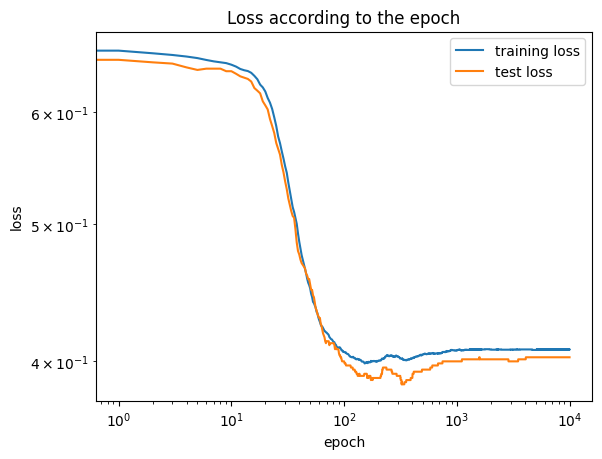

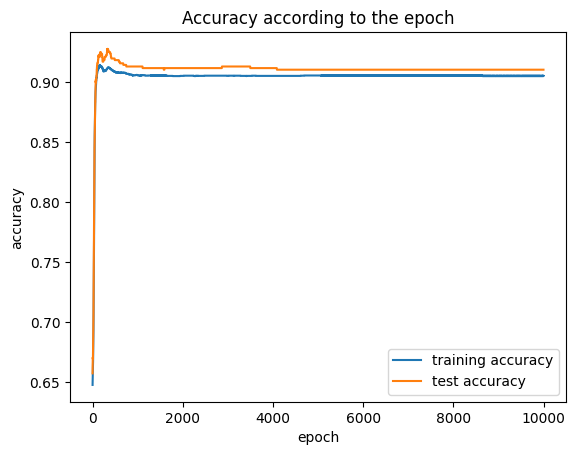

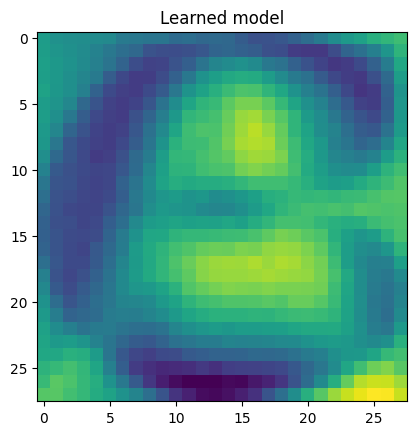

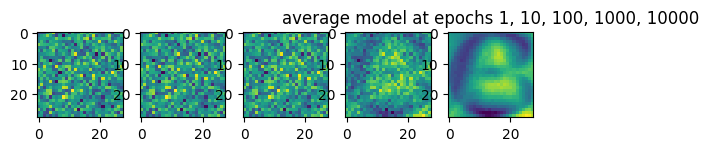

In [20]:
# /!\ CPU /!\ If this cell takes more than a minute to complete, you car change "lr" to 1e-2 and epochs to 100.
# It will still be more than enough to get smooth graphs and good results.

question_3.do("logist", lr = 1e-3, batch_size = 6000, epochs = 10000)

Training the model...


100%|██████████| 1/1 [00:02<00:00,  2.69s/it]


empirical error :  0.0
test error :  0.08933335542678833
Done.


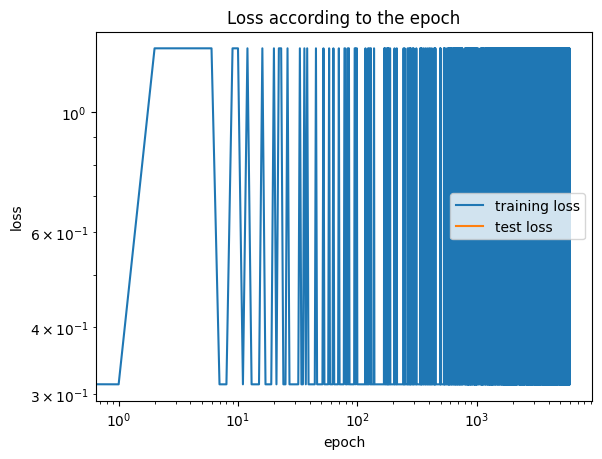

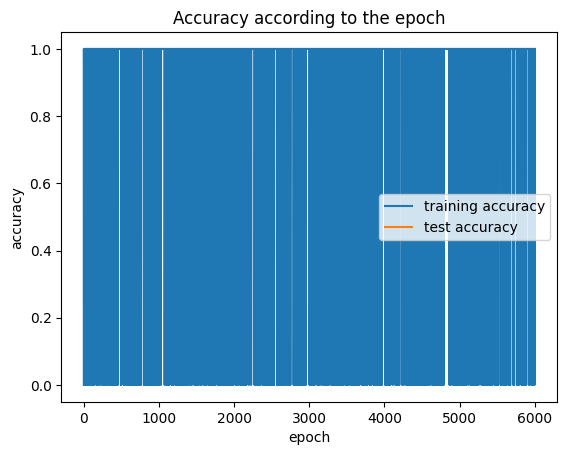

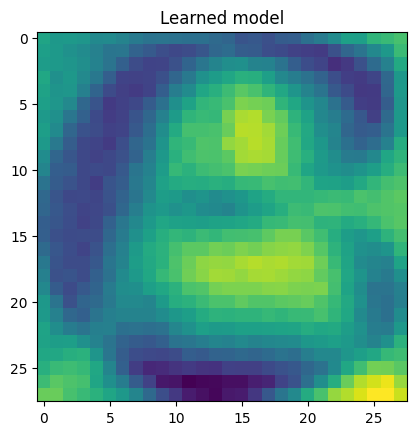

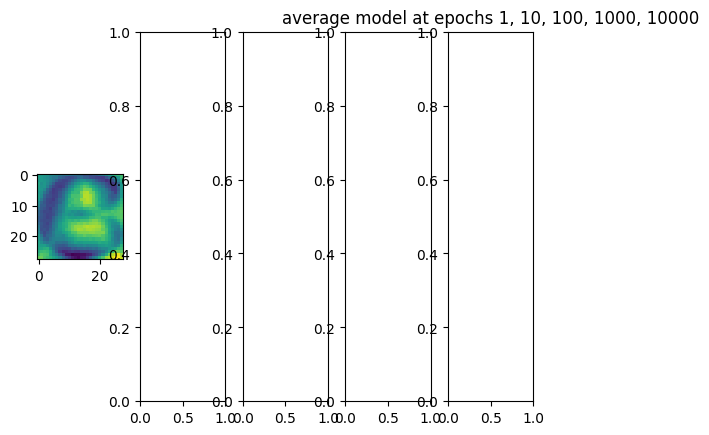

In [21]:
# /!\ CPU /!\ The remark of the previous cell still holds for this one and the two below.
# However, with a batch size of 1, the GPU actually slows everything, as the communication between components are taking now more time than the actual computation.

question_3.do("logist", lr = 1e-3, batch_size = 1, epochs = 1)

Training the model...


100%|██████████| 10000/10000 [01:41<00:00, 98.05it/s]


empirical error :  0.028833329677581787
test error :  0.06933331489562988
Done.


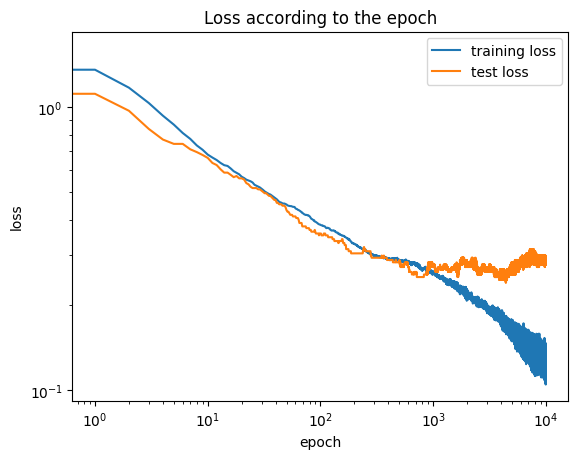

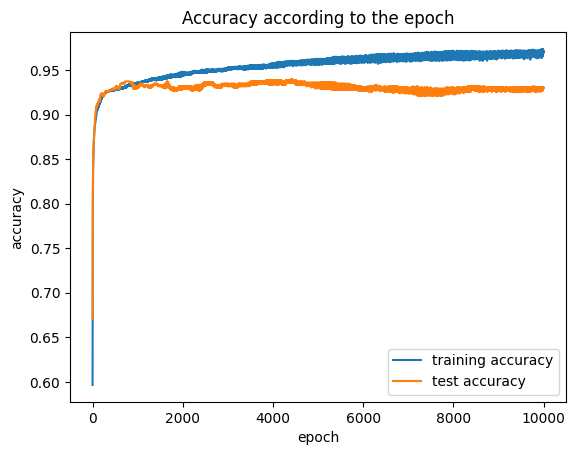

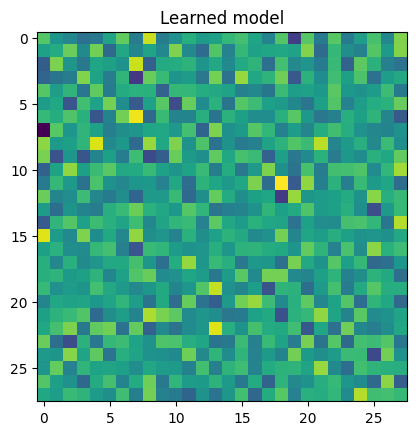

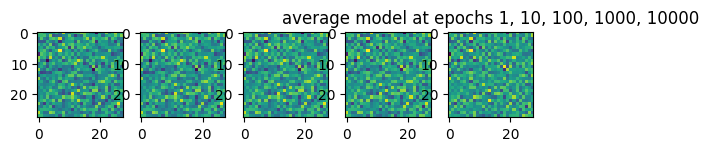

In [23]:
question_3.do("lin", lr = 1e-3, batch_size = 6000, epochs = 10000)

Training the model...


100%|██████████| 1/1 [00:01<00:00,  1.75s/it]


empirical error :  0.0
test error :  0.04933333396911621
Done.


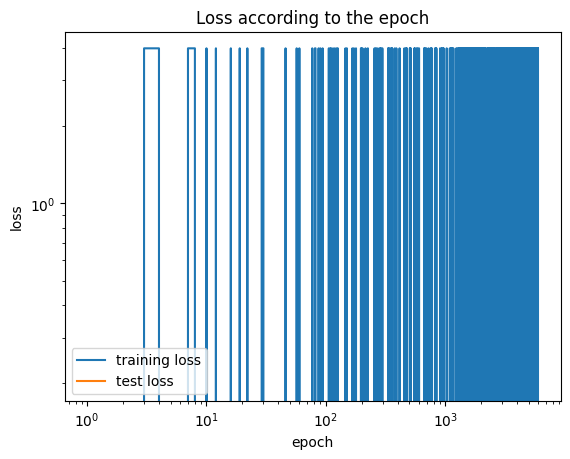

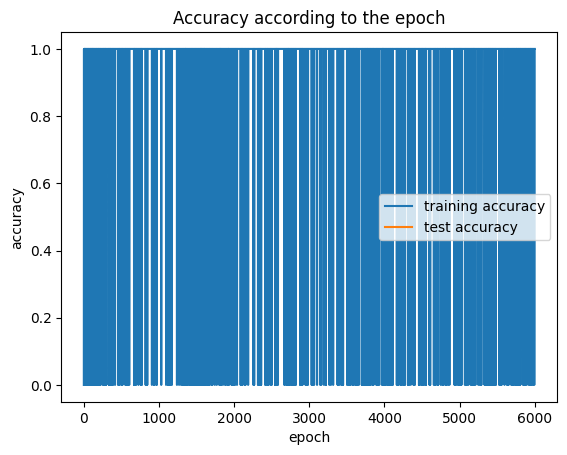

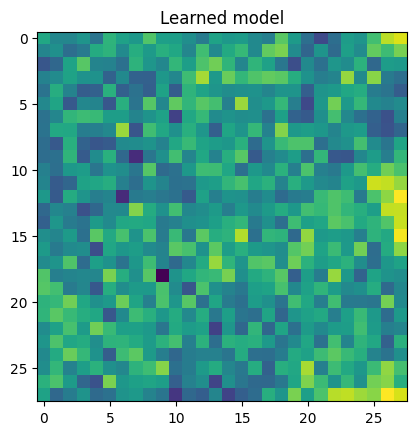

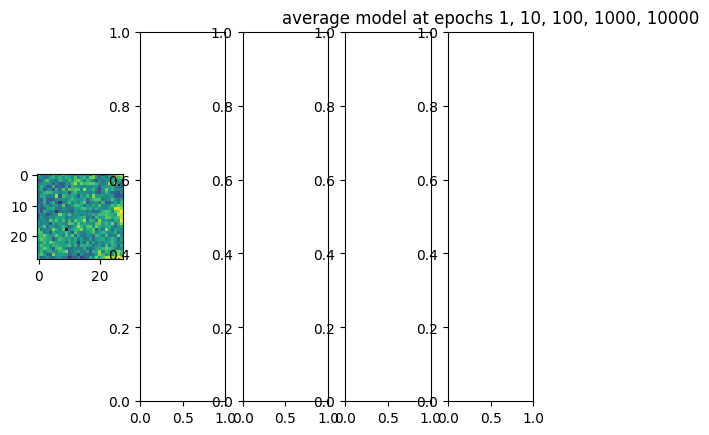

In [22]:
question_3.do("lin", lr = 1e-3, batch_size = 1, epochs = 1)

Now, question 4.

In [24]:
def knn(k, train_data, train_labels, test_data, test_labels):
    train_data_reshaped = train_data.reshape((train_data.shape[0], 28 * 28))
    test_data_reshaped = test_data.reshape((test_data.shape[0], 28 * 28))

    #compute the distances between each test point and each train point
    distances = torch.cdist(test_data_reshaped, train_data_reshaped)

    #find the k closest points for each test point
    closest = torch.argsort(distances, dim = 1)[:, :k]

    #find the labels of the k closest points
    closest_labels = train_labels[closest]

    #find the majority label for each test point
    majority_labels = torch.mode(closest_labels, dim = 1)[0]

    #compute the error
    error = torch.sum(majority_labels != test_labels).item() / 750

    return error

In [25]:
# /!\ CPU /!\ If this code is too slow, you can run for k = 1 - 10 instead of 1 - 100.

k_errors = torch.zeros(100)
ks = torch.arange(1, 101)
for k in range(1, 101):
    err = knn(k, train_data, train_labels, test_data, test_labels)
    print('k =', k, ':', err)
    k_errors[k - 1] = err

k = 1 : 0.04666666666666667
k = 2 : 0.056
k = 3 : 0.050666666666666665
k = 4 : 0.05466666666666667
k = 5 : 0.048
k = 6 : 0.052
k = 7 : 0.052
k = 8 : 0.052
k = 9 : 0.05333333333333334
k = 10 : 0.058666666666666666
k = 11 : 0.05466666666666667
k = 12 : 0.056
k = 13 : 0.050666666666666665
k = 14 : 0.05466666666666667
k = 15 : 0.05466666666666667
k = 16 : 0.05333333333333334
k = 17 : 0.05466666666666667
k = 18 : 0.05466666666666667
k = 19 : 0.056
k = 20 : 0.056
k = 21 : 0.056
k = 22 : 0.056
k = 23 : 0.056
k = 24 : 0.05733333333333333
k = 25 : 0.058666666666666666
k = 26 : 0.06
k = 27 : 0.06
k = 28 : 0.06
k = 29 : 0.06
k = 30 : 0.06133333333333333
k = 31 : 0.06266666666666666
k = 32 : 0.06
k = 33 : 0.06266666666666666
k = 34 : 0.06133333333333333
k = 35 : 0.06266666666666666
k = 36 : 0.06133333333333333
k = 37 : 0.06
k = 38 : 0.058666666666666666
k = 39 : 0.06
k = 40 : 0.06133333333333333
k = 41 : 0.06133333333333333
k = 42 : 0.06266666666666666
k = 43 : 0.06133333333333333
k = 44 : 0.06133

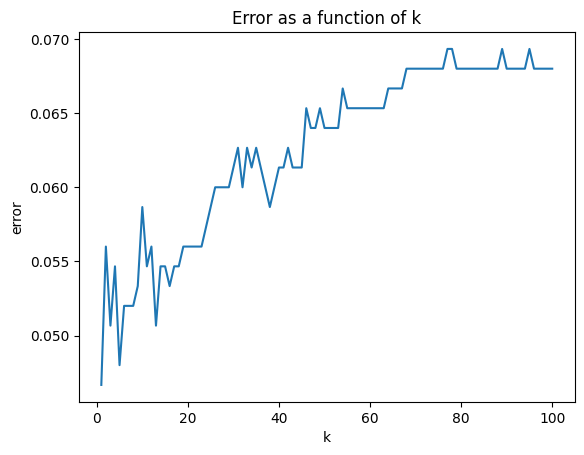

In [26]:
plt.plot(ks, k_errors)
plt.xlabel('k')
plt.ylabel('error')
plt.title('Error as a function of k')
plt.show()

In [27]:
def K_fold_cross_validation(K, train_data, train_labels, test_data, test_labels):
    #first, shuffle the data
    perm = torch.randperm(6000)
    shuffled_train_data = train_data[perm]
    shuffled_train_labels = train_labels[perm]

    #split the data into K folds
    folds = torch.split(shuffled_train_data, 6000 // K)
    folds_labels = torch.split(shuffled_train_labels, 6000 // K)

    #now, for each fold, train the model on the other folds and test it on the current fold
    k_list = torch.arange(1, 101)
    errors = torch.zeros(K, 100)
    for i in range(K):
        #first, we concatenate all the folds except the current one
        train_data = torch.cat(folds[:i] + folds[i + 1:])
        train_labels = torch.cat(folds_labels[:i] + folds_labels[i + 1:])

        #then, we test the model on the current fold
        test_data = folds[i]
        test_labels = folds_labels[i]

        #compute the error
        for k in k_list:
            errors[i, k - 1] = knn(k, train_data, train_labels, test_data, test_labels)

    #finally, we average the errors on the K folds and return the best k
    errors = torch.mean(errors, dim = 0)
    best_k = torch.argmin(errors) + 1

    return best_k.item()

In [28]:
# /!\ CPU /!\ If this code is too slow, you can run for k = 1 - 10 instead of 1 - 100.

best_k = K_fold_cross_validation(5, train_data, train_labels, test_data, test_labels)
print('\nbest k :', best_k)


best k : 3


In [33]:
#compute the training and test errors for the best k
test_error = knn(best_k, train_data, train_labels, test_data, test_labels)
train_error = knn(best_k, train_data, train_labels, train_data, train_labels)

print('empirical error :', train_error)
print('test error :', test_error)

empirical error : 0.176
test error : 0.050666666666666665


In [30]:
def kmeans(k, train_data, train_labels, test_data, test_labels):
    #reshape the images into vectors
    train_data = train_data.reshape((6000, 28 * 28))
    test_data = test_data.reshape((750, 28 * 28))

    #initialize the k points
    k0 = torch.randint(0, 6000, (1,)).item()
    k0 = train_data[k0]

    k_stack = torch.zeros((k, 28 * 28)).to(device)
    k_stack[0] = k0

    for i in range(k - 1):
        distances = torch.cdist(train_data, k_stack[:i + 1])
        
        #first, find the minimum distance between each point and the k points we already have
        #this gives the distance from each point to the closest point among the k points we already have
        #then, find the maximum of these minimums
        #this is the furthest point from the k points we already have

        min_distances = torch.min(distances, dim = 1)[0]
        #we take the [0] because the function returns a tuple with the values and the indices, we only want the values
        max_index = torch.argmax(min_distances)

        k_stack[i + 1] = train_data[max_index]

    #now we have initialized the k points, we can start the clustering process

    #until the representative points do not change anymore
    while True:
        #find the closest representative point for each data point
        distances = torch.cdist(train_data, k_stack)
        closest = torch.argmin(distances, dim = 1)

        #find the new representative points
        new_k_stack = torch.zeros((k, 28 * 28)).to(device)
        for i in range(k):
            #find the center of mass of the cluster
            new_k_stack[i] = torch.mean(train_data[closest == i], dim = 0)

        #check if the representative points have changed
        if torch.all(torch.eq(new_k_stack, k_stack)):
            break
        else:
            k_stack = new_k_stack

    #As the k clusters are not points of the data, we cannot use the labels of the data to test the model.
    #Instead, we will use the labels of the representative points.
    #We will then check if the closest representative point has the same label as the test point.
    #If it does, we will say that the test point is correctly classified.
    #If it does not, we will say that the test point is incorrectly classified.

    #find the labels of the representative points
    #to do so, we say that the label of a representative point is the label of the closest data point to it
    #thus the distance is computed between the representative point and the data points as the transpose of the distance between the data points and the representative points
    distances = torch.cdist(k_stack, train_data)
    closest = torch.argmin(distances, dim = 1)
    # TODO : test with the ponderated mean of the labels of the closest data points
    k_labels = train_labels[closest]

    #now we can test the model
    #find the closest representative point for each test point
    distances = torch.cdist(test_data, k_stack)
    closest = torch.argmin(distances, dim = 1)

    #check if the closest representative point has the same label as the test point
    correct = torch.eq(k_labels[closest], test_labels)

    #return the percentage of correctly classified test points
    test_accuracy = torch.sum(correct).item() / 750

    #repeat for the training data
    distances = torch.cdist(train_data, k_stack)
    closest = torch.argmin(distances, dim = 1)

    correct = torch.eq(k_labels[closest], train_labels)

    train_accuracy = torch.sum(correct).item() / 6000

    return k_stack, k_labels, train_accuracy, test_accuracy

In [31]:
#plot the training and test errors as a function of k
k_values = torch.arange(1, 11)

k_stack_list = []
k_labels_list = []

train_errors = torch.zeros(10)
test_errors = torch.zeros(10)
for i in tqdm(range(10)):
    k_stack, k_labels, train_accuracy, test_accuracy = kmeans(k_values[i], train_data, train_labels, test_data, test_labels)

    k_stack_list.append(k_stack)
    k_labels_list.append(k_labels)

    train_errors[i] = 1 - train_accuracy
    test_errors[i] = 1 - test_accuracy

#print the training and test errors
print('training errors :', train_errors)
print('test errors :', test_errors)

100%|██████████| 10/10 [00:10<00:00,  1.02s/it]

training errors : tensor([0.6667, 0.6667, 0.3723, 0.3627, 0.2740, 0.2613, 0.1920, 0.1058, 0.1300,
        0.0912])
test errors : tensor([0.6667, 0.6667, 0.3787, 0.3773, 0.3040, 0.2840, 0.1880, 0.1107, 0.1333,
        0.0960])


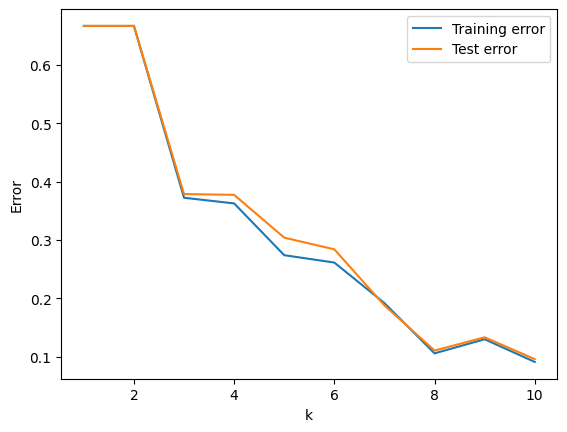

In [32]:
plt.plot(k_values, train_errors, label = 'Training error')
plt.plot(k_values, test_errors, label = 'Test error')
plt.xlabel('k')
plt.ylabel('Error')
plt.legend()
plt.show()